# SMABacktester Class

In [216]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from itertools import product

from typing import Tuple

class BackTesterData(DataFrame):
    Close: Series
    returns: Series
    sma_s: Series
    sma_l: Series
    position: Series
    strategy: Series
    creturns: Series
    cstrategy: Series

class SMABacktester():
    _data: BackTesterData

    def __init__(self, ticker:str, sma_s:int, sma_l:int, start:str, end:str):
        self._ticker = ticker
        self._sma_s = sma_s
        self._sma_l = sma_l
        self._start = start
        self._end = end

        self._load()
        self._config()

    def __repr__(self):
        return f'{SMABacktester.__name__}(symbol={self._ticker}, SMA_S={self._sma_s}, SMA_L={self._sma_l}, start={self._start}, end={self._end})'

    def _load(self):
        df: DataFrame = yf.download(self._ticker, start=self._start, end=self._end)["Close"]
        df = df.to_frame()
        df["returns"] = df["Close"].div(df["Close"].shift(1)).apply(np.log)
        self._compute_and_add_cols(df)

        self._data = df

    def _compute_and_add_cols(self, df, sma_s=None, sma_l=None):
        if sma_s is None:
            sma_s = self._sma_s
        if sma_l is None:
            sma_l = self._sma_l

        df["sma_s"] = df["Close"].rolling(sma_s).mean()
        df["sma_l"] = df["Close"].rolling(sma_l).mean()
        df.dropna(inplace=True)
        df["position"] = np.where(df["sma_s"] > df["sma_l"], 1, -1)
        df["strategy"] = df["returns"] * df["position"].shift(1)
        df.dropna(inplace=True)
        df["creturns"] = df["returns"].cumsum().apply(np.exp)
        df["cstrategy"] = df["strategy"].cumsum().apply(np.exp)

    def _config(self):
        plt.style.use('seaborn')

    @property
    def results(self):
        return self._data
    
    def get_perfs(self):
        ''' Returns (absolute return, out-performance against buy-and-hold)'''
        perf = self._data.cstrategy[-1]
        outperf = perf - self._data.creturns[-1]
        return (perf, outperf)

    def plot_results(self):
        self._data[["creturns", "cstrategy"]].plot(figsize=(15, 8))
        plt.title(f'{self._ticker} | SMA_S={self._sma_s} | SMA_L={self._sma_l}')
        plt.show()

    def set_params(self, sma_s:int, sma_l: int):
        self._sma_s = sma_s
        self._sma_l = sma_l
        self._compute_and_add_cols(self._data)

    def _get_perf(self, sma_s, sma_l):
        df: BackTesterData = self._data.copy()
        self._compute_and_add_cols(df, sma_s, sma_l)
        return np.exp(df.creturns[-1])

    def optimize_params(self, range_s_args: Tuple[int, int, int], range_l_args: Tuple[int, int, int]):
        range_s = range(*range_s_args)
        range_l = range(*range_l_args)
        pairs = list(product(range_s, range_l))
        results = []
        for s, l in pairs:
            results.append(self._get_perf(s, l))

        max_perf = np.max(results)
        max_index = np.argmax(results)
        max_pair = pairs[max_index]

        self._sma_s = max_pair[0]
        self._sma_l = max_pair[1]
        self._compute_and_add_cols(self._data)

        return (max_pair, max_perf)


    
    

In [217]:
tester = SMABacktester("EURUSD=X", 50, 200, '2004-01-01', '2020-06-30')

[*********************100%***********************]  1 of 1 completed


In [218]:
tester

SMABacktester(symbol=EURUSD=X, SMA_S=50, SMA_L=200, start=2004-01-01, end=2020-06-30)

In [219]:
tester.get_perfs()

(1.2835003323288539, 0.3676743925451338)

In [220]:
tester.results

,Close,returns,sma_s,sma_l,position,strategy,creturns,cstrategy
Date,,,,,,,,
2004-10-07,1.229906,0.001475,1.221840,1.226081,-1,-0.001475,1.001476,0.998526
2004-10-08,1.241003,0.008982,1.222628,1.225995,-1,-0.008982,1.010511,0.989598
2004-10-11,1.238405,-0.002095,1.223352,1.225843,-1,0.002095,1.008396,0.991673
2004-10-12,1.232104,-0.005102,1.223888,1.225643,-1,0.005102,1.003265,0.996746
2004-10-13,1.234903,0.002270,1.224466,1.225497,-1,-0.002270,1.005545,0.994486
...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,1.101794,1.103430,-1,-0.002892,0.921130,1.271272
2020-06-25,1.125087,-0.005449,1.102486,1.103540,-1,0.005449,0.916125,1.278218
2020-06-26,1.122208,-0.002562,1.103213,1.103627,-1,0.002562,0.913781,1.281497


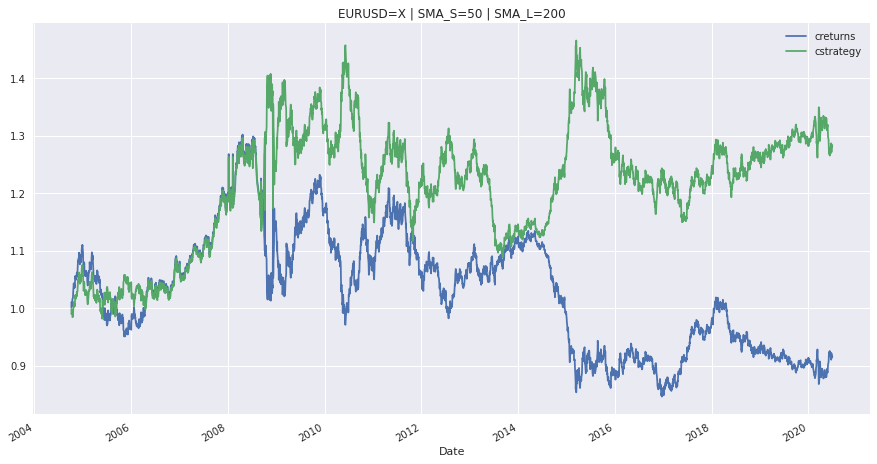

In [221]:
tester.plot_results()

In [222]:
tester.set_params(75, 150)

In [223]:
tester.get_perfs()

(1.4927671617089129, 0.6246631070362748)

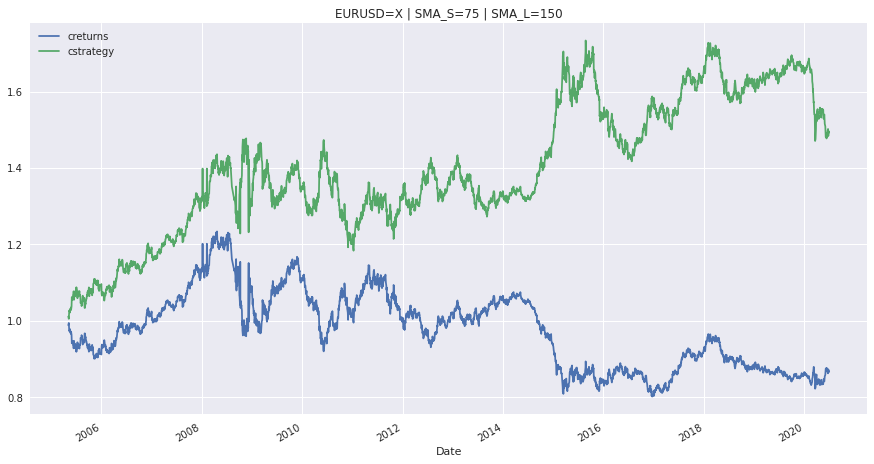

In [224]:
tester.plot_results()

In [225]:
tester.optimize_params((25, 50, 1), (100, 200, 1))

((25, 134), 2.6203598084501984)

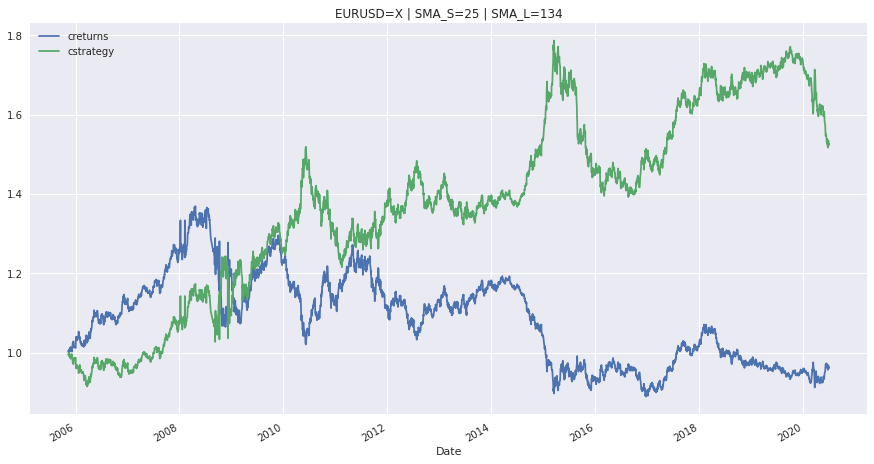

In [226]:
tester.plot_results()